<h2 align=center>Movie Review Classification with BERT & TensorFlow</h2>

In this [project](https://udemy.com/), you will learn how to fine-tune a BERT model for fake news classification using TensorFlow and TF-Hub.

## Task 1: Setup your TensorFlow and Colab Runtime.

### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).



In [21]:
!nvidia-smi

Fri Jan 29 04:20:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [22]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [ ]:
!pip install -q tensorflow==2.4.0

In [23]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2310/2310), done.
remote: Total 2650 (delta 508), reused 1388 (delta 307), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 29.87 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [1]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 5.8MB/s 
     |████████████████████████████████| 215kB 15.2MB/s 
     |████████████████████████████████| 296kB 74.0MB/s 
     |████████████████████████████████| 102kB 15.4MB/s 
     |████████████████████████████████| 25.9MB 123kB/s 
     |████████████████████████████████| 174kB 62.6MB/s 
     |████████████████████████████████| 3.7MB 56.9MB/s 
     |████████████████████████████████| 706kB 18.6MB/s 
     |████████████████████████████████| 358kB 60.3MB/s 
     |████████████████████████████████| 1.2MB 53.6MB/s 
     |████████████████████████████████| 11.5MB 63.1MB/s 
     |████████████████████████████████| 37.6MB 77kB/s 
     |████████████████████████████████| 645kB 67.7MB/s 
     |████████████████████████████████| 2.2MB 49.1MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-cloud

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)



## Task 2: Download and Import the Quora Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


## Task 3: **Download** Fake news Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/data/moviereviews/IMDB Dataset.csv' './moviereviews.csv'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('moviereviews.csv',low_memory=False)
df.shape
df.tail(20)


,review,sentiment
49980,A stunning film of high quality.<br /><br />Ap...,positive
49981,"And I repeat, please do not see this movie! Th...",negative
49982,"To be hones, I used to like this show and watc...",negative
49983,"I loved it, having been a fan of the original ...",positive
49984,Hello it is I Derrick Cannon and I welcome you...,negative
49985,Imaginary Heroes is clearly the best film of t...,positive
49986,This movie is a disgrace to the Major League F...,negative
49987,A remake of Alejandro Amenabar's Abre los Ojos...,negative
49988,"When I first tuned in on this morning news, I ...",negative
49989,I got this one a few weeks ago and love it! It...,positive


In [4]:
#check few rows in true news Dataset
df.tail(20)
df['text'] = df['review']
df['target'] = np.where(df['sentiment']=='positive', 1, 0)

In [5]:
#check few rows in fake news Dataset
df.tail(20)

,review,sentiment,text,target
49980,A stunning film of high quality.<br /><br />Ap...,positive,A stunning film of high quality.<br /><br />Ap...,1
49981,"And I repeat, please do not see this movie! Th...",negative,"And I repeat, please do not see this movie! Th...",0
49982,"To be hones, I used to like this show and watc...",negative,"To be hones, I used to like this show and watc...",0
49983,"I loved it, having been a fan of the original ...",positive,"I loved it, having been a fan of the original ...",1
49984,Hello it is I Derrick Cannon and I welcome you...,negative,Hello it is I Derrick Cannon and I welcome you...,0
49985,Imaginary Heroes is clearly the best film of t...,positive,Imaginary Heroes is clearly the best film of t...,1
49986,This movie is a disgrace to the Major League F...,negative,This movie is a disgrace to the Major League F...,0
49987,A remake of Alejandro Amenabar's Abre los Ojos...,negative,A remake of Alejandro Amenabar's Abre los Ojos...,0
49988,"When I first tuned in on this morning news, I ...",negative,"When I first tuned in on this morning news, I ...",0
49989,I got this one a few weeks ago and love it! It...,positive,I got this one a few weeks ago and love it! It...,1


(50000, 4)

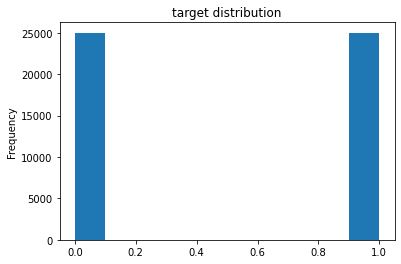

In [6]:
df.target.plot(kind='hist', title='target distribution')
df.shape

## Task 3: Create tf.data.Datasets for Training and Evaluation

In [7]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.9, stratify=df.target.values)
valid_df, remaining2 = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.target.values)
test_df, _  = train_test_split(remaining2, random_state=42, train_size=0.9, stratify=remaining2.target.values)


train_df.shape, valid_df.shape, test_df.shape

((45000, 4), (2500, 4), (2250, 4))

In [8]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['text'].values, valid_df['target'].values))
  test_data =  tf.data.Dataset.from_tensor_slices((test_df['text'].values, test_df['target'].values)) 
  for text, label in test_data.take(5):
    print(text)
    print(label)  

tf.Tensor(b"Lillian Hellman's play, adapted by Dashiell Hammett with help from Hellman, becomes a curious project to come out of gritty Warner Bros. Paul Lukas, reprising his Broadway role and winning the Best Actor Oscar, plays an anti-Nazi German underground leader fighting the Fascists, dragging his American wife and three children all over Europe before finding refuge in the States (via the Mexico border). They settle in Washington with the wife's wealthy mother and brother, though a boarder residing in the manor is immediately suspicious of the newcomers and spends an awful lot of time down at the German Embassy playing poker. It seems to take forever for this drama to find its focus, and when we realize what the heart of the material is (the wise, honest, direct refugees teaching the clueless, head-in-the-sand Americans how the world has suddenly changed), it seems a little patronizing--the viewer is quite literally put in the relatives' place, being lectured to. Lukas has severa

## Task 4: Download a Pre-trained BERT Model from TensorFlow Hub

In [9]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
 # 1 - Insincere Question
 # 0 - Sincere Question
label_list = [0,1]


 # maximum length of (token) input sequences
max_seq_length = 128
train_batch_size = 32



# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)




In [10]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [11]:
 tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [12]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [13]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_words_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_id': segment_ids
       }  
  return (x, label_id)
  

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [14]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [15]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [16]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [17]:
# Building the model
def create_model():
  input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_words_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_id")
  pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, input_type_id])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
           inputs = {
               'input_words_ids': input_words_ids,
               'input_mask': input_mask,
               'input_type_id': input_type_id          
           },
           outputs = output )
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [18]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_id (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_words_ids[0][0]            
                                                                 input_mask[0][0]             

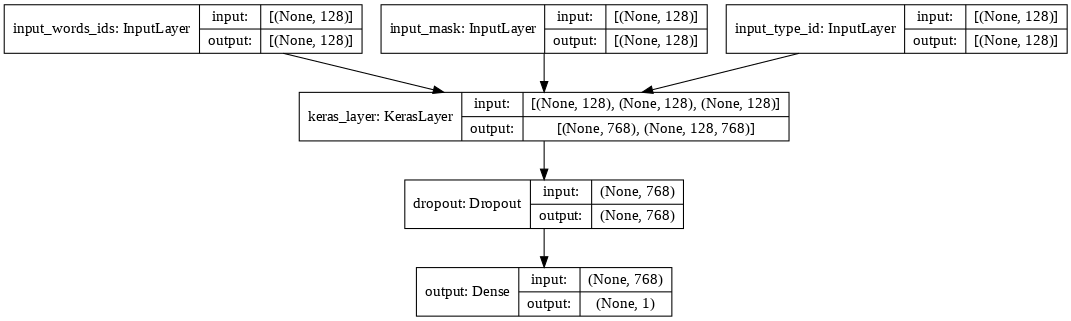

In [19]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [20]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
1406/1406 [==============================] - 690s 480ms/step - loss: 0.3805 - binary_accuracy: 0.8231 - val_loss: 0.2406 - val_binary_accuracy: 0.8986
Epoch 2/4
1406/1406 [==============================] - 678s 479ms/step - loss: 0.2169 - binary_accuracy: 0.9133 - val_loss: 0.2531 - val_binary_accuracy: 0.9026
Epoch 3/4
1406/1406 [==============================] - 678s 480ms/step - loss: 0.1256 - binary_accuracy: 0.9541 - val_loss: 0.2921 - val_binary_accuracy: 0.9034
Epoch 4/4
1406/1406 [==============================] - 680s 481ms/step - loss: 0.0620 - binary_accuracy: 0.9779 - val_loss: 0.3847 - val_binary_accuracy: 0.9018


## Task 11: Evaluate the BERT Text Classification Model

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

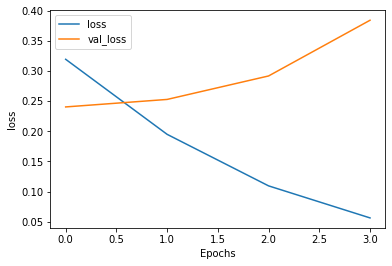

In [22]:
plot_graphs(history, 'loss')

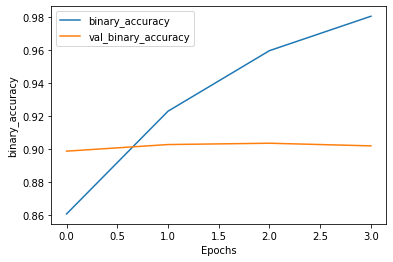

In [23]:
plot_graphs(history, 'binary_accuracy')

In [26]:
sample_example = ["Every once in a while a movie comes, that truly makes an impact. Joaquins performance and scenography in all its brilliance. Grotesque, haunting and cringy. Hard to watch at times,... but so mesmerizing, you wont blink an eye watching it. Tragic, but with seriously funny moments. Emotional rollercoaster - sometimes, with multiple emotions popping-up at the same time.", 
                  "This is a very poor remake of Dirty Rotten Scoundrels and unlike that movie this one lacks in humor and talent, Rebel Wilson is woeful yet again, do not waste your money, go and rewatch the original",
                  "I went into this film expecting an all-time classic based on the reviews I had read & what I ended up watching was just a decent film overall. Phoenix is outstanding...so he definitely did his part",
                  'Apart from Eddie, the film is full of brilliant performances, in particularly by Wesley Snipes who matches and sometimes steals the show from Eddie',
                  'Do yourself a favor, watch the original and save your money. I am so tired of remaking the old movies and catering to women, and yes, I am a women']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [1]*len(sample_example)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['positive' if pred >= threshold else 'negative' for pred in preds]



['positive', 'negative', 'positive', 'positive', 'negative']